## Zillow 2017 predictions report:

Got an email from the Zillow DS Team:

<i>"We want to be able to predict the property tax assessed values ('taxvaluedollarcnt') of Single Family Properties that had a transaction during 2017.

We have a model already, but we are hoping your insights can help us improve it. I need recommendations on a way to make a better model. <b>Maybe you will create a new feature out of existing ones</b> that works better, try a non-linear regression algorithm, or <b>try to create a different model for each county</b>. Whatever you find that works (or doesn't work) will be useful. Given you have just joined our team, we are excited to see your outside perspective.

One last thing, Zach lost the email that told us where these properties were located. Ugh, Zach :-/. Because property taxes are assessed at the county level, we would like to know what states and counties these are located in."</i>

-- The Zillow Data Science Team

___________________________________________________________________________________________________________________

## My Goal: to predict the values of single unit properties using the zillow database obervations from 2017.




### My Deliverables:

- Constructed ML Regression model that predicts propery tax assessed values (and can be used for our marketing and tech departments).

- Finding the key drivers of property value for single family properties. 


### My Questions: 
 

- Do count of bath/bedrooms drive the property value? And if so, is there one more weighted against the other?

- Is there a difference of the average of property values by county? And if so, what is the difference?


### Follow up Questions:

- Can we get data on the population income average per county?

- Can we get the data on school ratings (greatschools.com) and see if this might be a main driver as well?

- Can we gather predictions and data based on other location factors (ie parks, hiking, waterfronts, nearby churches, grocery stores, malls, etc)





In [1]:
#will insert and collect needed imports to repo along the workflow, down below:

In [90]:
import warnings
warnings.filterwarnings("ignore")

#imports for calling in data, cleaning
import pandas as pd
import os
from env import get_db_url
import prepare

#imports for exploration phase
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from sklearn.model_selection import train_test_split

#imports for stats, modeling and evaluation
from sklearn.preprocessing import MinMaxScaler, StandardScaler, RobustScaler, QuantileTransformer
from acquire import wrangle_zillow

import datetime
from math import sqrt
plt.rc("axes.spines", top=False, right=False)
from sklearn.linear_model import LinearRegression
from sklearn.feature_selection import f_regression
from sklearn.metrics import explained_variance_score

### Acquistion: 
INITIAL ACQUISITION:
We will be calling in the zillow dataset from the MySQL database.
This dataset will only with include taxvaluedollarcnt, bathroom count, bedroom count, calculatedfinishedsquarefeet, transactiondate and fips.

This dataset will also only take in transaction accounts from year 2017. 

In [3]:
# Using MySQL, we will Find all of the "Single Family Residential" properties and transactions from 2017:
df = pd.read_sql("SELECT bedroomcnt, bathroomcnt, calculatedfinishedsquarefeet, taxvaluedollarcnt, transactiondate, fips FROM properties_2017 JOIN predictions_2017 AS pe USING (parcelid) JOIN propertylandusetype USING (propertylandusetypeid) WHERE propertylandusetype.propertylandusedesc = 'Single Family Residential' AND pe.transactiondate LIKE '2017%%';", get_db_url("zillow"))
df.head()

,bedroomcnt,bathroomcnt,calculatedfinishedsquarefeet,taxvaluedollarcnt,transactiondate,fips
0,3.0,1.0,1012.0,79904.0,2017-01-13,6037.0
1,4.0,2.0,1242.0,590000.0,2017-01-13,6037.0
2,2.0,1.0,864.0,355000.0,2017-01-13,6037.0
3,3.0,2.0,1550.0,2200000.0,2017-01-13,6037.0
4,3.0,2.0,1149.0,185716.0,2017-01-13,6037.0


### Acquistion Summary: 
Getting to know the data in dtypes, and any missed nulls from prep


In [4]:
#noting that transactiondate is the only non-numeric column. 
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 52441 entries, 0 to 52440
Data columns (total 6 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   bedroomcnt                    52441 non-null  float64
 1   bathroomcnt                   52441 non-null  float64
 2   calculatedfinishedsquarefeet  52359 non-null  float64
 3   taxvaluedollarcnt             52440 non-null  float64
 4   transactiondate               52441 non-null  object 
 5   fips                          52441 non-null  float64
dtypes: float64(5), object(1)
memory usage: 2.4+ MB


In [5]:
#looking at the counts for each column
for column in df.columns:
    print(column)
    print(df[column].value_counts())
    print("-------------------------------")

bedroomcnt
3.0     23359
4.0     15240
2.0      8340
5.0      3973
6.0       635
1.0       612
0.0       137
7.0       106
8.0        24
9.0         8
12.0        3
10.0        2
14.0        1
11.0        1
Name: bedroomcnt, dtype: int64
-------------------------------
bathroomcnt
2.0     21893
3.0     10673
1.0      9568
2.5      3934
4.0      2227
3.5       918
1.5       841
5.0       803
4.5       687
6.0       322
5.5       224
0.0       121
7.0        88
8.0        53
6.5        47
7.5        16
9.0        13
10.0        5
11.0        3
8.5         3
18.0        1
13.0        1
Name: bathroomcnt, dtype: int64
-------------------------------
calculatedfinishedsquarefeet
1120.0    128
1200.0    119
1080.0    102
936.0      86
1040.0     86
         ... 
4207.0      1
3694.0      1
4773.0      1
9848.0      1
5124.0      1
Name: calculatedfinishedsquarefeet, Length: 4723, dtype: int64
-------------------------------
taxvaluedollarcnt
455000.0    34
600000.0    30
550000.0    24
45000

In [6]:
#Let's check for any nulls
df.isnull().sum()

bedroomcnt                       0
bathroomcnt                      0
calculatedfinishedsquarefeet    82
taxvaluedollarcnt                1
transactiondate                  0
fips                             0
dtype: int64

In [7]:
#If these nulls are dropped, will it effect the dataset?
round(df.dropna().shape[0] / df.shape[0], 4)

0.9984

### Prep-Clean:

In [8]:
#99% of our data still left? Great! Let's drop them!
df = df.dropna()
df.isnull().sum()

bedroomcnt                      0
bathroomcnt                     0
calculatedfinishedsquarefeet    0
taxvaluedollarcnt               0
transactiondate                 0
fips                            0
dtype: int64

#### Convert Datatyes

- I'll be changing bedroomcnt, finishedsquareft, taxvaluedollar, and fips into integers so as to utilize in continuous testing. 

- I will not change bathroomcnt due to some objects showing 1/2 baths.

- I will not change transaction date as it already is in the format I want. 

In [9]:
##Changing dtype of Fips code so only 4 digits (no decimals)
df['fips'] = df['fips'].astype('int')

In [10]:
#Changing dtype of squarefeet so no decimals
df['calculatedfinishedsquarefeet'] = df['calculatedfinishedsquarefeet'].astype('int')

In [11]:
#Changing dtype of taxvaluedollarcnt as integer
df['taxvaluedollarcnt'] = df['taxvaluedollarcnt'].astype('int')

In [12]:
#changing bedroom count to int
df['bedroomcnt']= df['bedroomcnt'].astype('int')

In [13]:
df.head()

,bedroomcnt,bathroomcnt,calculatedfinishedsquarefeet,taxvaluedollarcnt,transactiondate,fips
0,3,1.0,1012,79904,2017-01-13,6037
1,4,2.0,1242,590000,2017-01-13,6037
2,2,1.0,864,355000,2017-01-13,6037
3,3,2.0,1550,2200000,2017-01-13,6037
4,3,2.0,1149,185716,2017-01-13,6037


### Exploration and Visualization (looking at the data):

In [14]:
#taking a look at the mean and other data stats
df.describe().T

,count,mean,std,min,25%,50%,75%,max
bedroomcnt,52358.0,3.305531,0.941429,0.0,3.00,3.0,4.00,14.0
bathroomcnt,52358.0,2.302781,1.019773,0.0,2.00,2.0,3.00,18.0
calculatedfinishedsquarefeet,52358.0,1922.904618,1004.370420,128.0,1268.00,1659.0,2306.00,21929.0
taxvaluedollarcnt,52358.0,528025.819569,748329.465813,1000.0,193644.25,373376.5,618533.25,49061236.0
fips,52358.0,6049.111158,21.019623,6037.0,6037.00,6037.0,6059.00,6111.0


<AxesSubplot:>

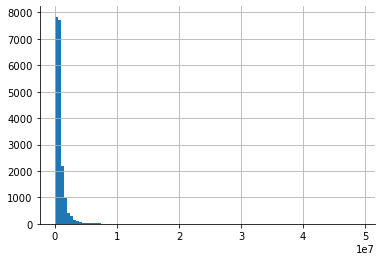

In [15]:
#looking at 100 properties where bathroom count is higher than average
df[df.bathroomcnt > 2.3].taxvaluedollarcnt.hist(bins=100)

<AxesSubplot:>

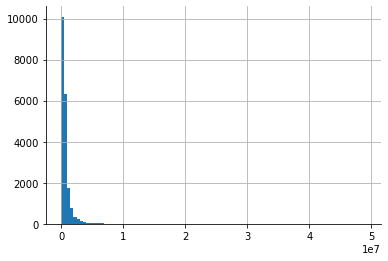

In [16]:
#looking at 100 properties where bedroom count is higher than average

df[df.bedroomcnt > 3.3 ].taxvaluedollarcnt.hist(bins=100)

#### More Visualizations

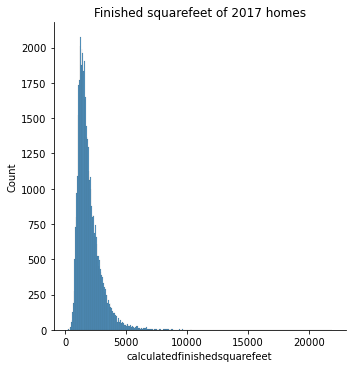

In [17]:
#using sns displot to see values of homes and the years built 
sns.displot(x='calculatedfinishedsquarefeet', data=df)

plt.title('Finished squarefeet of 2017 homes')
plt.show()

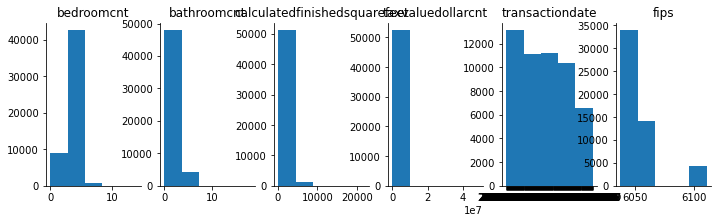

In [18]:
#creating histograms for all the variables

plt.figure(figsize=(16, 3))

# Creates a List of columns:
for i, col in enumerate(df.columns):

    # i starts at 0, but plot numbers should start at 1
    plot_number = i + 1 

    # Create subplot.
    plt.subplot(1,8, plot_number)

    # Title with column name.
    plt.title(col)

    # Display histogram for column.
    df[col].hist(bins=5)

    # Hide gridlines.
    plt.grid(False)

#### Takeaways:
Just these few visuals show me there are some outliers that need to be dropped

### Handling Outliers:
Seeing the size and count of the variables to locate any outliers

#### Squarefootage:

In [19]:
df.calculatedfinishedsquarefeet.sort_values(ascending=False).head(15)

2174     21929
14539    20612
7316     18654
48813    17245
27077    15450
41548    14829
28165    13598
16552    12616
48263    12056
4249     12039
5647     11880
46706    11722
22190    11704
3754     11703
11641    11649
Name: calculatedfinishedsquarefeet, dtype: int64

I'm thinking of narrowing down to only a range of below 9,000sqft homes

In [20]:
#let's see the percentage if we narrowed it down from there
df[df.calculatedfinishedsquarefeet <= 9_000].shape[0] / df.shape[0]


0.9989304404293518

I still would have 99.8% of my data. I feel comfortable narrowing things down to this.


In [21]:
 df = df[df.calculatedfinishedsquarefeet <= 9_000]

Let's look at the lower sqft end:

In [22]:
df[df.calculatedfinishedsquarefeet >= 200].shape[0] / df.shape[0]

0.9999617605445299

Again, I feel comfortable narrowing from this end too:

In [23]:
df = df[df.calculatedfinishedsquarefeet >= 200]

#### Bedroom Count:

In [24]:
df.bedroomcnt.sort_values(ascending=False).head(15)

31642    12
31641    12
31643    12
21165    11
33907    10
28209     9
49355     9
44252     9
6425      9
11416     9
5291      9
1695      8
47881     8
36666     8
7035      8
Name: bedroomcnt, dtype: int64

Hmm...what if I get rid of homes with more than 6 bedrooms?

In [25]:
df[df.bedroomcnt <= 6].shape[0] / df.shape[0]

0.9976099426386233

In [26]:
#that looks good:
df = df[df.bedroomcnt <= 6]

I also will get rid of zero bedrooms as my industry source says these are similar to nulls:

In [27]:
df[df.bedroomcnt != 0].shape[0] / df.shape[0]

0.9988116914230953

In [28]:
#yep, still leaves us with 99.8%
df=df[df.bedroomcnt != 0]

#### Bathroom Count

In [29]:
df.bathroomcnt.sort_values(ascending=False).head(15)

12619    9.0
38176    9.0
17246    9.0
19961    8.5
4254     8.0
46327    8.0
11189    8.0
7056     8.0
4925     8.0
6686     8.0
39768    8.0
12548    8.0
34869    8.0
29198    8.0
44788    8.0
Name: bathroomcnt, dtype: float64

ok. Maybe let's see how much data is left with 6 or less baths?

In [30]:
df[df.bathroomcnt <= 6].shape[0] / df.shape[0]

0.9970256941646038

In [31]:
#cool, let's narrow it here too:
df = df[df.bathroomcnt <= 6]

In [32]:
#also getting rid of properties with no baths
df=df[df.bathroomcnt != 0]

In [33]:
#Let's see how much data we have still....
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 51942 entries, 0 to 52440
Data columns (total 6 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   bedroomcnt                    51942 non-null  int64  
 1   bathroomcnt                   51942 non-null  float64
 2   calculatedfinishedsquarefeet  51942 non-null  int64  
 3   taxvaluedollarcnt             51942 non-null  int64  
 4   transactiondate               51942 non-null  object 
 5   fips                          51942 non-null  int64  
dtypes: float64(1), int64(4), object(1)
memory usage: 2.8+ MB


In [34]:
#looking at the counts for each column
for column in df.columns:
    print(column)
    print(df[column].value_counts())
    print("-------------------------------")

bedroomcnt
3    23351
4    15218
2     8334
5     3891
1      605
6      543
Name: bedroomcnt, dtype: int64
-------------------------------
bathroomcnt
2.0    21879
3.0    10644
1.0     9544
2.5     3932
4.0     2203
3.5      915
1.5      840
5.0      786
4.5      679
6.0      297
5.5      223
Name: bathroomcnt, dtype: int64
-------------------------------
calculatedfinishedsquarefeet
1120    127
1200    118
1080    102
1040     86
936      86
       ... 
4128      1
4482      1
6571      1
5322      1
5124      1
Name: calculatedfinishedsquarefeet, Length: 4489, dtype: int64
-------------------------------
taxvaluedollarcnt
455000    34
600000    30
500000    24
450000    24
550000    24
          ..
159489     1
161962     1
317075     1
635345     1
33325      1
Name: taxvaluedollarcnt, Length: 38507, dtype: int64
-------------------------------
transactiondate
2017-06-30    802
2017-04-28    610
2017-05-31    559
2017-07-28    540
2017-08-31    522
             ... 
2017-08-13     

#### Assessed Value of Home:
Let's see what outliers are here...

In [35]:
df.taxvaluedollarcnt.sort_values(ascending=False).head(15)

50749    20203475
39015    15618488
48383    13600098
8195     13198250
31892    13128583
34899    11317682
36239    11020600
43578    11000000
38704    10873908
3771     10610405
50762    10355345
24259    10130485
50475    10050974
41562     9935000
37553     9870514
Name: taxvaluedollarcnt, dtype: int64

Wow. Maybe I'll see what it looks like for 2M homes or less...

In [36]:
df[df.taxvaluedollarcnt <= 2_000_000].shape[0] / df.shape[0]

0.9771475876939664

In [37]:
#I'll try a little bit more, to get to 98 or 99% still left
df[df.taxvaluedollarcnt <= 2_500_000].shape[0] / df.shape[0]

0.9861961418505256

Yep. Let's take these outliers out too

In [38]:
df = df[df.taxvaluedollarcnt <= 2_500_000]

In [39]:
#other end:
df[df.taxvaluedollarcnt >= 45_000].shape[0] / df.shape[0]

0.9808882381649585

I don't know who is buying these homes at 45,000, but good for them...and I'm taking out the lower end ones

In [40]:
df = df[df.taxvaluedollarcnt >= 45_000]

In [41]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 50246 entries, 0 to 52440
Data columns (total 6 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   bedroomcnt                    50246 non-null  int64  
 1   bathroomcnt                   50246 non-null  float64
 2   calculatedfinishedsquarefeet  50246 non-null  int64  
 3   taxvaluedollarcnt             50246 non-null  int64  
 4   transactiondate               50246 non-null  object 
 5   fips                          50246 non-null  int64  
dtypes: float64(1), int64(4), object(1)
memory usage: 2.7+ MB


____________________________________________________________________________________________________________

### Missing county/fips codes in:
Thanks Zach for losing those fip codes! ;) 
Here is a function to add those back in.

In [42]:
def clearing_fips(df):
    '''This function takes in a DataFrame of unprepared Zillow information and generates a new
    'county' column, with the county name based on the FIPS code. 
    '''
    # create a list of our conditions
    fips = [
        (df['fips'] == 6037),
        (df['fips'] == 6059),
        (df['fips'] == 6111)
        ]
    # create a list of the values we want to assign for each condition
    counties = ['Los Angeles County', 'Orange County', 'Ventura County']
    # create a new column and use np.select to assign values to it using our lists as arguments
    df['county'] = np.select(fips, counties)
    return df

In [43]:
clearing_fips(df)

,bedroomcnt,bathroomcnt,calculatedfinishedsquarefeet,taxvaluedollarcnt,transactiondate,fips,county
0,3,1.0,1012,79904,2017-01-13,6037,Los Angeles County
1,4,2.0,1242,590000,2017-01-13,6037,Los Angeles County
2,2,1.0,864,355000,2017-01-13,6037,Los Angeles County
3,3,2.0,1550,2200000,2017-01-13,6037,Los Angeles County
4,3,2.0,1149,185716,2017-01-13,6037,Los Angeles County
...,...,...,...,...,...,...,...
52435,4,2.0,1440,585000,2017-09-06,6059,Orange County
52436,4,2.0,1669,569544,2017-09-06,6059,Orange County
52437,3,2.0,1821,402132,2017-09-06,6037,Los Angeles County
52438,2,1.0,1246,468691,2017-09-06,6037,Los Angeles County


___________________________________________________________________________________________________________

### Creating a new feature to compare value weight to property value:
Time of year for Transactions

I added this as I know (from buying my own homes) that there are high buying and high selling seasons in real estate.

In [44]:
#creating a function to added a column that holds the month number for later testing
def month_sales(df):
    df['month'] = pd.DatetimeIndex(df['transactiondate']).month
    return df

In [45]:
month_sales(df)

,bedroomcnt,bathroomcnt,calculatedfinishedsquarefeet,taxvaluedollarcnt,transactiondate,fips,county,month
0,3,1.0,1012,79904,2017-01-13,6037,Los Angeles County,1
1,4,2.0,1242,590000,2017-01-13,6037,Los Angeles County,1
2,2,1.0,864,355000,2017-01-13,6037,Los Angeles County,1
3,3,2.0,1550,2200000,2017-01-13,6037,Los Angeles County,1
4,3,2.0,1149,185716,2017-01-13,6037,Los Angeles County,1
...,...,...,...,...,...,...,...,...
52435,4,2.0,1440,585000,2017-09-06,6059,Orange County,9
52436,4,2.0,1669,569544,2017-09-06,6059,Orange County,9
52437,3,2.0,1821,402132,2017-09-06,6037,Los Angeles County,9
52438,2,1.0,1246,468691,2017-09-06,6037,Los Angeles County,9


### >>ALL THE ABOVE IS NOW ADDED INTO THE ACQUIRE .py file<<

_____________________________________________________________________________________________________________________

## Splitting the Data:

- Let's split the data to begin the train, validate, and test process and do some Hypothesis testing:
**<b>Note: this function will be added to the prepare.py file

In [46]:
#Splitting the data into a train/test split of 80/20
#Further splits for train/validate of 70/30
train_validate, test = train_test_split(df, test_size=.2, random_state=123)
train, validate = train_test_split(train_validate, test_size=.3, random_state=123)
print(train.shape, validate.shape, test.shape)

(28137, 8) (12059, 8) (10050, 8)


### Questions 1: Does Bathroom and Bedroom count determine a property's value?

a = 0.05

- H0: Bathroom count does not correlate to property value.
- Ha: Bathroom count does correlate to property value.

In [47]:
#We will try a correlation hypothesis test for bathroom count and taxvaluedollarcnt (property value)
from math import sqrt
from scipy import stats

n = train.shape[0]     # number of observations
degf = n - 2        # degrees of freedom: the # of values in the final calculation of a statistic that are free to vary.
conf_interval = .95 # desired confidence interval
α = 1 - conf_interval

x = train.bathroomcnt
y = train.taxvaluedollarcnt

def stdev(x):
    variance = ((x - x.mean()) ** 2).sum() / n
    return sqrt(variance)

r_xy = (((x - x.mean()) * (y - y.mean())).sum() / n) / (stdev(x) * stdev(y))
print('The correlation coefficient is:', r_xy)


The correlation coefficient is: 0.5026911482573438


In [48]:
#calculating corresponding p-value:
# 1 step: t-statistic
t = (r_xy * sqrt(n - 2)) / sqrt(1 - r_xy**2)
t

97.53864966410656

In [49]:
# 2 step: find p value:
p = stats.t.sf(t, df=degf) * 2 # *2 for a two-tailed test
p

0.0

In [50]:
# 3 step: compare p value to our alpha: if our p value is less, then we reject Null Hypothesis

p < α


True

#### We reject the null hypothesis that bathroom count does not correlate to a property's value. 

In [51]:
# Let's visualize these coefficient correlations with a heatmap!
#Creating the correlation matrix for bathroom counts.

bathroom_corr = train.drop(columns=['bathroomcnt']).corr()
bathroom_corr


,bedroomcnt,calculatedfinishedsquarefeet,taxvaluedollarcnt,fips,month
bedroomcnt,1.000000,0.626469,0.262354,0.145977,0.011893
calculatedfinishedsquarefeet,0.626469,1.000000,0.578090,0.131102,0.009785
taxvaluedollarcnt,0.262354,0.578090,1.000000,0.073670,0.011889
fips,0.145977,0.131102,0.073670,1.000000,0.005202
month,0.011893,0.009785,0.011889,0.005202,1.000000


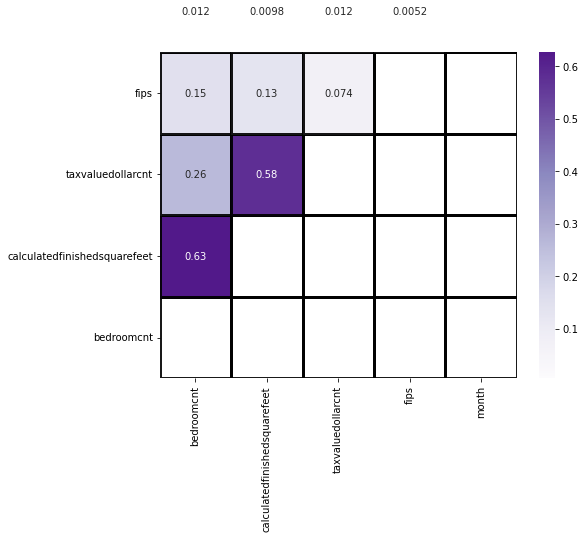

In [52]:
# Pass my correlation matrix to Seaborn's heatmap.

kwargs = {'alpha':.9,'linewidth':3, 'linestyle':'-', 
          'linecolor':'k','rasterized':False, 'edgecolor':'w', 
          'capstyle':'projecting',}

plt.figure(figsize=(8,6))
sns.heatmap(bathroom_corr, cmap='Purples', annot=True, mask= np.triu(bathroom_corr), **kwargs)
plt.ylim(0, 4)

plt.show()


#### TAKEAWAY: Bathroom count looks to definitely correlate with property's value, and it looks like the finished squarefeet may relate to bathroom count too

___________________________________________________________________________________________________________________

Part two of the first question::
a = 0.05

- H0: Bedroom count does not correlate to property value.
- Ha: Bedroom count does correlate to property value.

In [53]:
#We will try a correlation hypothesis test for bathroom count and taxvaluedollarcnt (property value)
from math import sqrt
from scipy import stats

n = train.shape[0]     # number of observations
degf = n - 2        # degrees of freedom: the # of values in the final calculation of a statistic that are free to vary.
conf_interval = .95 # desired confidence interval
α = 1 - conf_interval

x = train.bedroomcnt
y = train.taxvaluedollarcnt

def stdev(x):
    variance = ((x - x.mean()) ** 2).sum() / n
    return sqrt(variance)

r_xy = (((x - x.mean()) * (y - y.mean())).sum() / n) / (stdev(x) * stdev(y))
print('The correlation coefficient is:', r_xy)

The correlation coefficient is: 0.2623535083309769


In [54]:
#calculating corresponding p-value:
# 1 step: t-statistic
t = (r_xy * sqrt(n - 2)) / sqrt(1 - r_xy**2)
t

45.60324003305357

In [55]:
# 2 step: find p value:
p = stats.t.sf(t, df=degf) * 2 # *2 for a two-tailed test
p

0.0

In [56]:
# 3 step: compare p value to our alpha: if our p value is less, then we reject Null Hypothesis

p < α


True

#### We reject the null hypothesis that bedroom count does not correlate to a property's value. 


In [57]:
# Let's visualize these coefficient correlations with a heatmap!
#Creating the correlation matrix for bedroom counts.

bedroom_corr = train.drop(columns=['bedroomcnt']).corr()
bedroom_corr


,bathroomcnt,calculatedfinishedsquarefeet,taxvaluedollarcnt,fips,month
bathroomcnt,1.000000,0.833742,0.502691,0.120997,0.011969
calculatedfinishedsquarefeet,0.833742,1.000000,0.578090,0.131102,0.009785
taxvaluedollarcnt,0.502691,0.578090,1.000000,0.073670,0.011889
fips,0.120997,0.131102,0.073670,1.000000,0.005202
month,0.011969,0.009785,0.011889,0.005202,1.000000


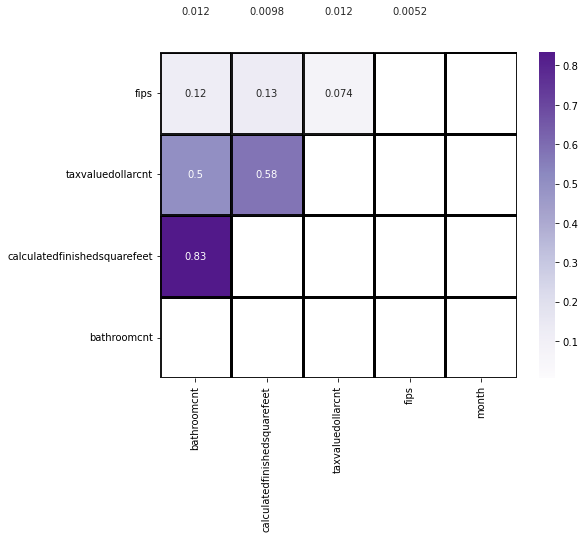

In [58]:
# Pass my correlation matrix to Seaborn's heatmap.

kwargs = {'alpha':.9,'linewidth':3, 'linestyle':'-', 
          'linecolor':'k','rasterized':False, 'edgecolor':'w', 
          'capstyle':'projecting',}

plt.figure(figsize=(8,6))
sns.heatmap(bedroom_corr, cmap='Purples', annot=True, mask= np.triu(bedroom_corr), **kwargs)
plt.ylim(0, 4)

plt.show()

#### TAKEAWAY: Bedroom count looks to definitely correlate with property's value, and it looks like the finished squarefeet With correlation to bathroom count....makes sense though. The more rooms the more bathrooms may be needed!

___________________________________________________________________________________________________________________

### Questions 2: - Is there a difference of the average of property values by county? And if so, what is the difference?

a = 0.05

- H0: County does not correlate to property value.
- Ha: County does correlate to property value.

In [59]:
#We will try a correlation hypothesis test for county (fips as it needs to be numeric)
from math import sqrt
from scipy import stats

n = train.shape[0]     # number of observations
degf = n - 2        # degrees of freedom: the # of values in the final calculation of a statistic that are free to vary.
conf_interval = .95 # desired confidence interval
α = 1 - conf_interval

x = train.fips
y = train.taxvaluedollarcnt

def stdev(x):
    variance = ((x - x.mean()) ** 2).sum() / n
    return sqrt(variance)

r_xy = (((x - x.mean()) * (y - y.mean())).sum() / n) / (stdev(x) * stdev(y))
print('The correlation coefficient is:', r_xy)

The correlation coefficient is: 0.0736698259963967


In [60]:
#calculating corresponding p-value:
# 1 step: t-statistic
t = (r_xy * sqrt(n - 2)) / sqrt(1 - r_xy**2)
t

12.390670963864315

In [61]:
# 2 step: find p value:
p = stats.t.sf(t, df=degf) * 2 # *2 for a two-tailed test
p

3.6268656953900946e-35

In [62]:
# 3 step: compare p value to our alpha: if our p value is less, then we reject Null Hypothesis

p < α


True

#### We reject the null hypothesis that county does not correlate to a property's value. 


__________________________________________________________________________________________________________________

### Let's begin looking at our data a bit more by county:

In [63]:
#getting a value_count() by each county
train.county.value_counts()

Los Angeles County    18048
Orange County          7701
Ventura County         2388
Name: county, dtype: int64

Now, Let's create some visuals to see the correlation/relationship 
between county and property value AND we can also add in the bathroom/bedroom counts too here per county

**<b>Note: this function has been added to the viz.py file

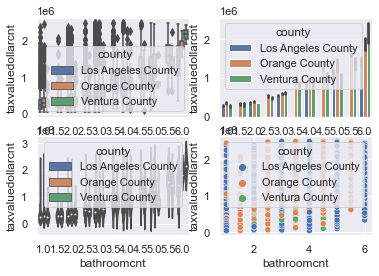

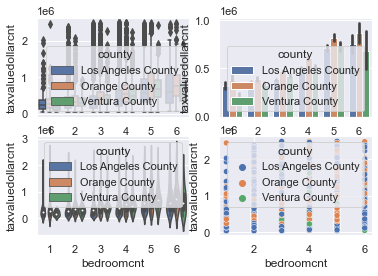

In [64]:
#creating a function that will show 3 different types of plots of the relation between property value/county/features
#all divided into county 
def plot_categorical_and_continuous_vars():
    columns = ['bathroomcnt','bedroomcnt']
    for x in columns:
        sns.set()
        fig, axes = plt.subplots(2,2)
        sns.boxplot(x= x, y="taxvaluedollarcnt", data=train, hue = 'county', ax = axes[0,0])
        sns.barplot(x= x, y="taxvaluedollarcnt", data=train, hue = 'county', ax = axes[0,1])
        sns.violinplot(x= x, y="taxvaluedollarcnt", data=train, hue = 'county', ax = axes[1,0])
        sns.scatterplot(x= x, y="taxvaluedollarcnt", data=train, hue = 'county', ax = axes[1,1])
plot_categorical_and_continuous_vars()
    

#### TAKEAWAY: The charts definitely highlight the rise of property value based on bathroom count, bedroom count and county.

___________________________________________________________________________________________________________________

Last chart per county.
- I found this one to be interesting in adding the regression line within the correlation between county and finished squarefeet
- I used 1/4 of the training data here so that a closer view of what the data errors look like, and also the confidence intervals

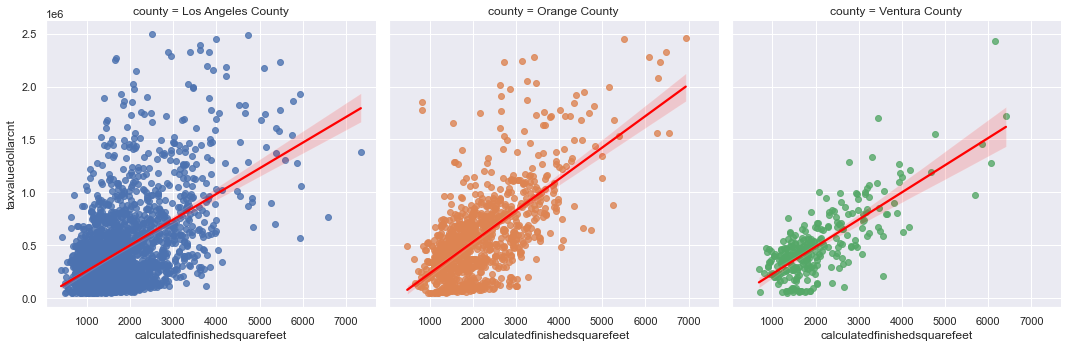

In [65]:
#looking at calculated finished squarefeet and if we can visually gauge any relation here
def plot_variable_pairs():
    columns = ['calculatedfinishedsquarefeet']
    for col in columns:
        sns.lmplot(x= col, y="taxvaluedollarcnt", data=train.sample(3500), col = 'county', hue = 'county', line_kws={'color': 'red'})
        
plot_variable_pairs()

In [66]:
#TODO: 
#add prepare functions/test and split to prepare.py
#add chart functions to viz.py


### Scale the Data:
I want to look at the distribution of my data one more time so I can decide if I want to use a linear or non-linear scale.

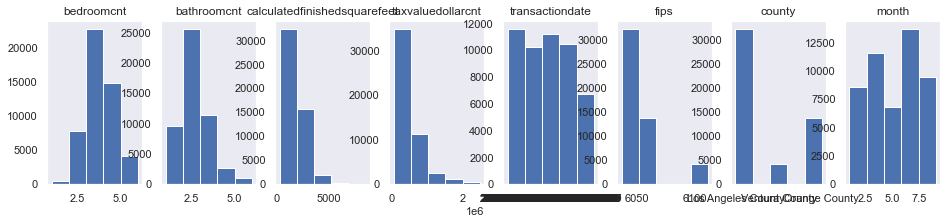

In [67]:
#creating histograms for all the variables

plt.figure(figsize=(16, 3))

# Creates a List of columns:
for i, col in enumerate(train.columns):

    # i starts at 0, but plot numbers should start at 1
    plot_number = i + 1 

    # Create subplot.
    plt.subplot(1,8, plot_number)

    # Title with column name.
    plt.title(col)

    # Display histogram for column.
    df[col].hist(bins=5)

    # Hide gridlines.
    plt.grid(False)

#### For the main features: Bedroom count, Bathroom count and finished squarefeet of properities, we already have a normal distribution, so I will use a Linear Scaler. (but later, I may try again a nonlinear scaler to look at the transaction date and months)

- I will create another split (to keep the unscaled data for possible futher exploring later):

In [68]:
#using a modified copy of the list, I will use Min-Max scaling
#MUST fit scaling to the train columns I am wanting to scale (ie columns_to_scale)
train_scaled = train.copy()
scaler = MinMaxScaler()
columns_to_scale = ['bedroomcnt','bathroomcnt','calculatedfinishedsquarefeet']

#A copy of train.                 #adding sklearn scaler.fit_transform to scale wanted columns
train_scaled[columns_to_scale] = scaler.fit_transform(train[columns_to_scale])

In [69]:
#Let's look at the data now scaled
train_scaled

,bedroomcnt,bathroomcnt,calculatedfinishedsquarefeet,taxvaluedollarcnt,transactiondate,fips,county,month
49714,0.4,0.2,0.158388,676931,2017-08-25,6037,Los Angeles County,8
48758,0.2,0.6,0.357667,1299520,2017-08-30,6059,Orange County,8
20886,0.4,0.2,0.152856,280659,2017-05-04,6059,Orange County,5
42450,0.8,0.4,0.293927,294744,2017-08-02,6037,Los Angeles County,8
19447,0.4,0.2,0.089477,367613,2017-04-14,6037,Los Angeles County,4
...,...,...,...,...,...,...,...,...
7754,0.8,0.4,0.287192,464307,2017-02-03,6059,Orange County,2
47482,0.4,0.2,0.162598,161000,2017-09-05,6037,Los Angeles County,9
4334,0.2,0.0,0.081419,137564,2017-01-19,6037,Los Angeles County,1
14980,0.8,0.3,0.351293,664680,2017-04-06,6059,Orange County,4


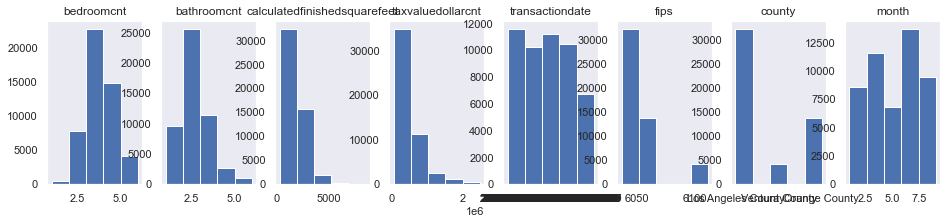

In [70]:
#creating histograms for all the train_scaled variables
columns = ['bedroomcnt','bathroomcnt','calculatedfinishedsquarefeet','taxvaluedollarcnt']
plt.figure(figsize=(16, 3))

# Creates a List of columns:
for i, col in enumerate(train_scaled.columns):

    # i starts at 0, but plot numbers should start at 1
    plot_number = i + 1 

    # Create subplot.
    plt.subplot(1,8, plot_number)

    # Title with column name.
    plt.title(col)

    # Display histogram for column.
    df[col].hist(bins=5)

    # Hide gridlines.
    plt.grid(False)


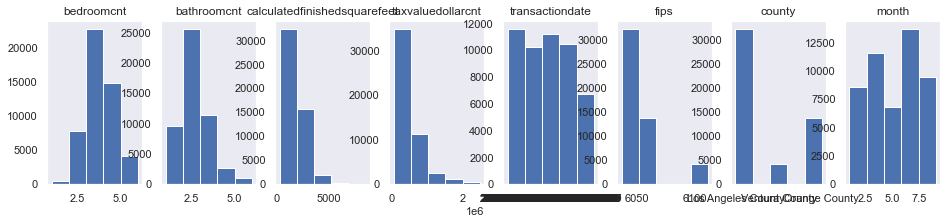

In [71]:
#compared to unscaled data
columns = ['bedroomcnt','bathroomcnt','calculatedfinishedsquarefeet','taxvaluedollarcnt']
plt.figure(figsize=(16, 3))

# Creates a List of columns:
for i, col in enumerate(train.columns):

    # i starts at 0, but plot numbers should start at 1
    plot_number = i + 1 

    # Create subplot.
    plt.subplot(1,8, plot_number)

    # Title with column name.
    plt.title(col)

    # Display histogram for column.
    df[col].hist(bins=5)

    # Hide gridlines.
    plt.grid(False)


In [72]:
#here is my data pipeline function for scaling:
def scale_data(train,
              validate,
              test,
              columns_to_scale=['bedroomcnt', 'bathroomcnt', 'calculatedfinishedsquarefeet'],
              return_scaler=False):
    """
    Scales the 3 data splits.
    Takes in train, validate and test data splits and then returns their scaled counterparts.
    If return_scaler is True, the scaler object will be returned as well
    """
    train_scaled = train.copy()
    validate_scaled = validate.copy()
    test_scaled = test.copy()
    
    #using MinMaxScaler (best showing distribution once scaled)
    scaler = MinMaxScaler()
    scaler.fit(train[columns_to_scale])
    
    #creating a df that puts MinMaxScaler to work on the wanted columns and returns the split datasets and counterparts
    train_scaled[columns_to_scale] = pd.DataFrame(scaler.transform(train[columns_to_scale]),
                                                 columns=train[columns_to_scale].columns.values).set_index([train.index.values])
    
    validate_scaled[columns_to_scale] = pd.DataFrame(scaler.transform(validate[columns_to_scale]),
                                                 columns=validate[columns_to_scale].columns.values).set_index([validate.index.values])
    
    test_scaled[columns_to_scale] = pd.DataFrame(scaler.transform(test[columns_to_scale]),
                                                 columns=test[columns_to_scale].columns.values).set_index([test.index.values])
    
    if return_scaler:
        return scaler, train_scaled, validate_scaled, test_scaled
    else:
        return train_scaled, validate_scaled, test_scaled

In [73]:
scaler, train_scaled, validate_scaled, test_scaled = scale_data(train, validate, test, return_scaler=True)

In [74]:
train_scaled

,bedroomcnt,bathroomcnt,calculatedfinishedsquarefeet,taxvaluedollarcnt,transactiondate,fips,county,month
49714,0.4,0.2,0.158388,676931,2017-08-25,6037,Los Angeles County,8
48758,0.2,0.6,0.357667,1299520,2017-08-30,6059,Orange County,8
20886,0.4,0.2,0.152856,280659,2017-05-04,6059,Orange County,5
42450,0.8,0.4,0.293927,294744,2017-08-02,6037,Los Angeles County,8
19447,0.4,0.2,0.089477,367613,2017-04-14,6037,Los Angeles County,4
...,...,...,...,...,...,...,...,...
7754,0.8,0.4,0.287192,464307,2017-02-03,6059,Orange County,2
47482,0.4,0.2,0.162598,161000,2017-09-05,6037,Los Angeles County,9
4334,0.2,0.0,0.081419,137564,2017-01-19,6037,Los Angeles County,1
14980,0.8,0.3,0.351293,664680,2017-04-06,6059,Orange County,4


### >>Above has been added to prepare.py file! <<

___________________________________________________________________________________________________________________

## Evaluating Regression Models:

Now I will be evaluating different Regression models performances (or in other terms, measuring how well a model can predict property value based on the dataset features. 

In this section I will evaluate how well each model performs by firt establishing a baseline (Zillow's current property value predictor), I will then computing metrics and compare those metrics across multiple models (including the baseline).

#### First model evaluation: Ordinary Least Squares:

In [91]:

# create the model object
lm = LinearRegression(normalize=True)

# fit the model to training data
lm.fit(train_scaled[['calculatedfinishedsquarefeet']], train_scaled.taxvaluedollarcnt)

# make prediction
train_scaled['yhat'] = lm.predict(train_scaled[['calculatedfinishedsquarefeet']])

train_scaled

,bedroomcnt,bathroomcnt,calculatedfinishedsquarefeet,taxvaluedollarcnt,transactiondate,fips,county,month,yhat,baseline,residual,baseline_residual,residual^2,baseline_residual^2
49714,0.4,0.2,0.158388,676931,2017-08-25,6037,Los Angeles County,8,401188.591766,469804.007215,275742.408234,207126.992785,7.603388e+10,4.290159e+10
48758,0.2,0.6,0.357667,1299520,2017-08-30,6059,Orange County,8,840298.568114,469804.007215,459221.431886,829715.992785,2.108843e+11,6.884286e+11
20886,0.4,0.2,0.152856,280659,2017-05-04,6059,Orange County,5,388998.453618,469804.007215,-108339.453618,-189145.007215,1.173744e+10,3.577583e+10
42450,0.8,0.4,0.293927,294744,2017-08-02,6037,Los Angeles County,8,699846.976404,469804.007215,-405102.976404,-175060.007215,1.641084e+11,3.064601e+10
19447,0.4,0.2,0.089477,367613,2017-04-14,6037,Los Angeles County,4,249341.870917,469804.007215,118271.129083,-102191.007215,1.398806e+10,1.044300e+10
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7754,0.8,0.4,0.287192,464307,2017-02-03,6059,Orange County,2,685006.808223,469804.007215,-220699.808223,-5497.007215,4.870841e+10,3.021709e+07
47482,0.4,0.2,0.162598,161000,2017-09-05,6037,Los Angeles County,9,410463.696879,469804.007215,-249463.696879,-308804.007215,6.223214e+10,9.535991e+10
4334,0.2,0.0,0.081419,137564,2017-01-19,6037,Los Angeles County,1,231586.669700,469804.007215,-94022.669700,-332240.007215,8.840262e+09,1.103834e+11
14980,0.8,0.3,0.351293,664680,2017-04-06,6059,Orange County,4,826253.408943,469804.007215,-161573.408943,194875.992785,2.610597e+10,3.797665e+10


In [92]:
#creating the zillow predictor baseline aka mean, of taxvaluedollarcnt(y)
baseline = train_scaled.taxvaluedollarcnt.mean()
baseline

469804.0072146995

In [93]:
#let's add the baseline to the the dataframe
train_scaled['baseline'] = train_scaled.taxvaluedollarcnt.mean()
train_scaled.head()

,bedroomcnt,bathroomcnt,calculatedfinishedsquarefeet,taxvaluedollarcnt,transactiondate,fips,county,month,yhat,baseline,residual,baseline_residual,residual^2,baseline_residual^2
49714,0.4,0.2,0.158388,676931,2017-08-25,6037,Los Angeles County,8,401188.591766,469804.007215,275742.408234,207126.992785,7.603388e+10,4.290159e+10
48758,0.2,0.6,0.357667,1299520,2017-08-30,6059,Orange County,8,840298.568114,469804.007215,459221.431886,829715.992785,2.108843e+11,6.884286e+11
20886,0.4,0.2,0.152856,280659,2017-05-04,6059,Orange County,5,388998.453618,469804.007215,-108339.453618,-189145.007215,1.173744e+10,3.577583e+10
42450,0.8,0.4,0.293927,294744,2017-08-02,6037,Los Angeles County,8,699846.976404,469804.007215,-405102.976404,-175060.007215,1.641084e+11,3.064601e+10
19447,0.4,0.2,0.089477,367613,2017-04-14,6037,Los Angeles County,4,249341.870917,469804.007215,118271.129083,-102191.007215,1.398806e+10,1.044300e+10


- Now, I want to plot the residuals for the OLS model I made:

In [94]:
# first I need to create residuals (ie residuals = actual - predicted)
train_scaled['residual'] = train_scaled.taxvaluedollarcnt - train_scaled.yhat
train_scaled['baseline_residual'] = train_scaled.taxvaluedollarcnt - train_scaled.baseline
train_scaled.head()

,bedroomcnt,bathroomcnt,calculatedfinishedsquarefeet,taxvaluedollarcnt,transactiondate,fips,county,month,yhat,baseline,residual,baseline_residual,residual^2,baseline_residual^2
49714,0.4,0.2,0.158388,676931,2017-08-25,6037,Los Angeles County,8,401188.591766,469804.007215,275742.408234,207126.992785,7.603388e+10,4.290159e+10
48758,0.2,0.6,0.357667,1299520,2017-08-30,6059,Orange County,8,840298.568114,469804.007215,459221.431886,829715.992785,2.108843e+11,6.884286e+11
20886,0.4,0.2,0.152856,280659,2017-05-04,6059,Orange County,5,388998.453618,469804.007215,-108339.453618,-189145.007215,1.173744e+10,3.577583e+10
42450,0.8,0.4,0.293927,294744,2017-08-02,6037,Los Angeles County,8,699846.976404,469804.007215,-405102.976404,-175060.007215,1.641084e+11,3.064601e+10
19447,0.4,0.2,0.089477,367613,2017-04-14,6037,Los Angeles County,4,249341.870917,469804.007215,118271.129083,-102191.007215,1.398806e+10,1.044300e+10


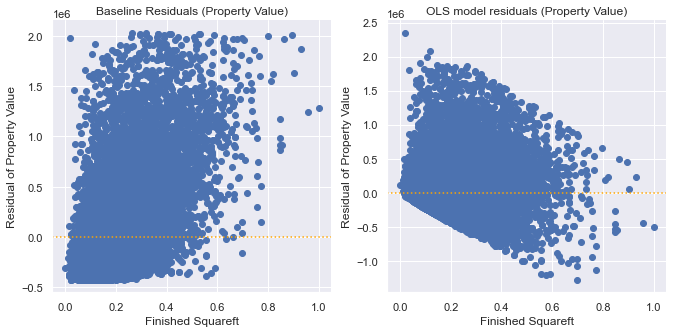

In [95]:
#Let's plot!
#Here are the residual plots (calculated finished square feet vs residual)

###METHODS USED:

plt.figure(figsize = (11,5))

plt.subplot(121)
plt.scatter(train_scaled.calculatedfinishedsquarefeet, train_scaled.baseline_residual)
plt.axhline(y = 0, ls = ':', color ='orange')
plt.xlabel('Finished Squareft')
plt.ylabel('Residual of Property Value')
plt.title('Baseline Residuals (Property Value)')

plt.subplot(122)
plt.scatter(train_scaled.calculatedfinishedsquarefeet, train_scaled.residual)
plt.axhline(y = 0, ls = ':', color ='orange')
plt.xlabel('Finished Squareft')
plt.ylabel('Residual of Property Value')
plt.title('OLS model residuals (Property Value)');

#### Evaluate Statistically:
Next, let's look at the stats side of this model. I can evaluate statistically with:
- Calculating the sum of squared errors, 
- explained sum of squares, 
- total sum of squares, 
- mean squared error, 
- and root mean squared error for your model.

Then, I will calculate the sum of squared errors, mean squared error, and root mean squared error for the baseline model for comparison sake (i.e. a model that always predicts the average taxvaluedollarcnt amount).



In [96]:
# I first will calculate the square of residuals (makes all the residuals positive)

train_scaled['residual^2'] = train_scaled.residual**2
train_scaled['baseline_residual^2'] = train_scaled.baseline_residual**2

train_scaled.head()

,bedroomcnt,bathroomcnt,calculatedfinishedsquarefeet,taxvaluedollarcnt,transactiondate,fips,county,month,yhat,baseline,residual,baseline_residual,residual^2,baseline_residual^2
49714,0.4,0.2,0.158388,676931,2017-08-25,6037,Los Angeles County,8,401188.591766,469804.007215,275742.408234,207126.992785,7.603388e+10,4.290159e+10
48758,0.2,0.6,0.357667,1299520,2017-08-30,6059,Orange County,8,840298.568114,469804.007215,459221.431886,829715.992785,2.108843e+11,6.884286e+11
20886,0.4,0.2,0.152856,280659,2017-05-04,6059,Orange County,5,388998.453618,469804.007215,-108339.453618,-189145.007215,1.173744e+10,3.577583e+10
42450,0.8,0.4,0.293927,294744,2017-08-02,6037,Los Angeles County,8,699846.976404,469804.007215,-405102.976404,-175060.007215,1.641084e+11,3.064601e+10
19447,0.4,0.2,0.089477,367613,2017-04-14,6037,Los Angeles County,4,249341.870917,469804.007215,118271.129083,-102191.007215,1.398806e+10,1.044300e+10


In [97]:
#SUM OF SQUARED ERRORS:
SSE = train_scaled['residual^2'].sum()
SSE_baseline = train_scaled['baseline_residual^2'].sum()

print('SSE =', "{:.1f}".format(SSE))
print("SSE Baseline =", "{:.1f}".format(SSE_baseline))
if SSE < SSE_baseline:
    print ('Model beats baseline')
else:
    print ('Baseline beats model')

SSE = 2838962323483758.5
SSE Baseline = 4263910006338606.0
Model beats baseline


In [82]:
#MEAN OF SQUARED ERROR: (error at each observation level)
MSE = SSE/len(train_scaled)
MSE_baseline = SSE_baseline/len(train_scaled)

print("MSE = ", "{:.1f}".format(MSE))
print("MSE baseline = ", "{:.1f}".format(MSE_baseline))
if MSE < MSE_baseline:
    print ('Model beats baseline')
else:
    print ('Baseline beats model')

MSE =  100897832870.7
MSE baseline =  151541031607.4
Model beats baseline


In [83]:
#TOTAL SUM OF SQUARES
TSS = SSE = train_scaled['residual^2'].sum()
TSS_baseline = SSE_baseline = train_scaled['baseline_residual^2'].sum()
print("TSS = ","{:.1f}".format(TSS)) 
print("TSS_baseline = ","{:.1f}".format(TSS_baseline))
if TSS < TSS_baseline:
    print ('Model beats baseline')
else:
    print ('Baseline beats model')

TSS =  2838962323483758.5
TSS_baseline =  4263910006338606.0
Model beats baseline


In [84]:
#EXPLAINED SUM of SQUARES
ESS = TSS - SSE
ESS_baseline = TSS_baseline - SSE-baseline
print("ESS = ","{:.1f}".format(ESS))
print("ESS_baseline = ","{:.1f}".format(ESS_baseline))

ESS =  0.0
ESS_baseline =  1424947682385043.5


In [85]:
#ROOT MEAN SQUARED ERROR
RMSE = sqrt(MSE)
RMSE_baseline =  sqrt(MSE_baseline)


print("RMSE = ", "{:.1f}".format(RMSE))
print("RMSE baseline = ", "{:.1f}".format(RMSE_baseline))


RMSE =  317644.2
RMSE baseline =  389282.7


In [86]:
ols_eval = pd.DataFrame(np.array(['SSE','MSE','RMSE']), columns=['metric'])
ols_baseline_eval = pd.DataFrame(np.array(['SSE_baseline','MSE_baseline','RMSE_baseline']), columns=['metric'])

ols_eval['model_error'] = np.array([SSE, MSE, RMSE])
ols_baseline_eval['model_error'] = np.array([SSE_baseline, MSE_baseline, RMSE_baseline])

print(ols_eval)
print(ols_baseline_eval)


  metric   model_error
0    SSE  2.838962e+15
1    MSE  1.008978e+11
2   RMSE  3.176442e+05
          metric   model_error
0   SSE_baseline  4.263910e+15
1   MSE_baseline  1.515410e+11
2  RMSE_baseline  3.892827e+05


In [87]:
ols_eval['error_delta'] = ols_eval.model_error - ols_baseline_eval.model_error
ols_eval


,metric,model_error,error_delta
0,SSE,2.838962e+15,-1.424948e+15
1,MSE,1.008978e+11,-5.064320e+10
2,RMSE,3.176442e+05,-7.163852e+04


Text(103, 90, '')

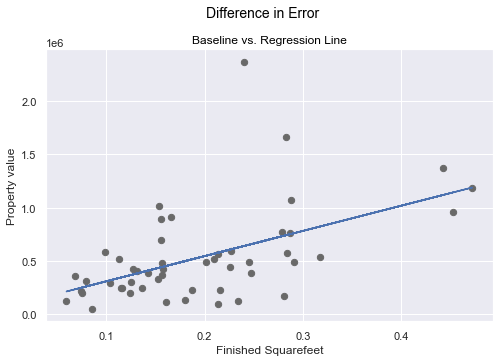

In [88]:
sample = train_scaled.sample(50)
baseline = sample.baseline
yhat = sample.yhat
x = sample.calculatedfinishedsquarefeet
y = sample.taxvaluedollarcnt


plt.figure(figsize=(8, 5))
## plot data points, regression line and baseline
    # plot the data points 
plt.scatter(x, y, color='dimgray', s=40)

#### plot the regression line
#obtain m (slope) and b(intercept) of linear regression line
m, b = np.polyfit(x, y, 1)
#add linear regression line to scatterplot 
plt.plot(x, m*x+b)

# add baseline through annotation
plt.annotate('', xy=(0.25, y.mean()), xytext=(0.25, y.mean()), xycoords='data', textcoords='data', arrowprops={'arrowstyle': '-', 'color': 'orange', 'linewidth': 2, 'alpha': .75})

#### set and plot title, subtitle, and axis labels
# set titles
title_string = r'Difference in Error'
subtitle_string = "Baseline vs. Regression Line"

    # add titles
plt.title(subtitle_string, fontsize=12, color='black')
plt.suptitle(title_string, y=1, fontsize=14, color='black')
    
    # add axes labels
plt.ylabel('Property value')
plt.xlabel('Finished Squarefeet')

# annotate some of the error lines with pointers
    # add pointer: the first data point to the regression line
plt.annotate('.', xy=(70.25, 70), xytext=(73, 70), xycoords='data', textcoords='data', arrowprops={'arrowstyle': 'fancy', 'color':'darkseagreen', 'linewidth': 1})

    # add pointer: the last data point to the regression line
plt.annotate('', xy=(100.25, 97), xytext=(103, 97), xycoords='data', textcoords='data', arrowprops={'arrowstyle': 'fancy', 'color':'darkseagreen', 'linewidth': 1})

    # add pointer: the last data point to the baseline 
plt.annotate('', xy=(100.25, 90), xytext=(103, 90), xycoords='data', textcoords='data', arrowprops={'arrowstyle': 'fancy', 'color':'goldenrod', 'linewidth': 1})

    ## ----------------------------------------
    ## add text to the annotatations
    # the error of the first data point to the regression line
#plt.text(73, 70, 4.1, ha='left', va='center', color='black')

    # the error of the last data point to the regression line
#plt.text(103, 96, 1.6, ha='left', va='center', color='black')

    # the error of the last data point to the baseline
#plt.text(103, 90, -12.7, ha='left', va='center', color='black')


In [100]:
evs = explained_variance_score(train_scaled.taxvaluedollarcnt, train_scaled.yhat)
print('Explained Variance = ', round(evs,3))


Explained Variance =  0.334


##### Takeaway here:

- When only using one predictor (finished squarefeet) to determine property value, the OLS model is predicting too high on the lower squarefoot properties and too low on the larger squarefoot properties.

- <b>My assessment: 
    - The stats tests are showing that the OLS model is still doing better than baseline...even with too high/low predictors.
    - More features predictors for this test would probably make the model even better.

### Feature Engineering:

### Modeling:

NEXT STEPS: